<a href="https://colab.research.google.com/github/YousraAshour/Head-Pose-Estimation/blob/main/Head_Pose_Estimation_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q opencv-python
!pip install -q mediapipe
!pip install -q mediapipe

In [2]:
import os
import cv2
import glob
import warnings
import mediapipe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import train_test_split
import scipy.io as sio
from pathlib import Path
from math import cos, sin
import random
from random import choice
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from zipfile import ZipFile
names_path=[]
with ZipFile('/content/drive/MyDrive/ITI/Projects/Head-Pose-Estimation/AFLW2000-3D.zip', 'r') as zipObject:
   
   # Extract all the contents of zip file in different directory
   zipObject.extractall('/content/')
   listOfFileNames = zipObject.namelist()

   for fileName in listOfFileNames:
       if fileName.endswith('.jpg'):
           # Extract a single file from zip
           names_path.append(zipObject.extract(fileName).split('.')[0])
len(names_path)           
          

2000

In [6]:
dir_path = '/content/AFLW2000/'
paths = os.listdir(dir_path)
names = [x.split('.')[0] for x in paths if x.endswith('.jpg')]

In [7]:
faceModule = mediapipe.solutions.face_mesh
len(names_path)

2000

In [8]:
landmarks=[]
res_imgs=[]
X=[]
Y=[]
poses=[]
for path in names_path:
    with faceModule.FaceMesh(static_image_mode=True) as face:
      image = cv2.imread(path + '.jpg')
      points = face.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      
      if points.multi_face_landmarks: 

          landmark=points.multi_face_landmarks[0]
          res_imgs.append(path)
          x_local=[]
          y_local=[]
          for points in landmark.landmark:
            x= points.x
            y= points.y

            shape = image.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            # X_features
            x_local.append(relative_x)
            # Y_features
            y_local.append(relative_y)

          
          X.append(np.array(x_local))
          Y.append(np.array(y_local))

          mat_file = sio.loadmat(path +'.mat')
          pose_para = mat_file["Pose_Para"][0][:3]
          poses.append(np.array(pose_para)) 
          

In [28]:
poses=np.array(poses)
X=np.array(X)
Y=np.array(Y)

pitch_label = poses[:,0]

yaw_label = poses[:,1]

roll_label = poses[:,2]
print(X.shape)
print(Y.shape)
print(poses.shape)

(1853, 468)
(1853, 468)
(1853, 3)


In [27]:
Mean_X = X - X[:,1].reshape(-1,1)
Mean_Y = Y - Y[:,1].reshape(-1,1)

X_171 = X[:,171]
X_10 = X[:,10]
Y_171 = Y[:,171]
Y_10 = Y[:,10]

distance = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_171,Y_171)),axis = 0).reshape(-1,1)
Norm_X = Mean_X / distance
Norm_Y = Mean_Y / distance

print(Norm_X.shape)
print(Norm_Y.shape)

features = np.hstack([Norm_X,Norm_Y])
print(features.shape)

(1853, 468)
(1853, 468)
(1853, 936)


In [11]:
X_train,X_val,Y_train,Y_val = train_test_split(features,poses, test_size=0.2, random_state=20)

In [12]:
# st=StandardScaler()
# X_train=st.fit_transform(X_train)
# X_val=st.transform(X_val)


In [13]:
Y_train_pitch= Y_train[:,0]
Y_train_yaw=  Y_train[:,1]
Y_train_roll=  Y_train[:,2]

Y_val_pitch=  Y_val[:,0]
Y_val_yaw=  Y_val[:,1]
Y_val_roll=  Y_val[:,2]


In [14]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

pitch_model =  SVR(C=100, kernel='poly')
# XGBRegressor(learning_rate=0.8999999999999999, max_depth=1, n_estimators=13,verbosity=0)


pitch_model.fit(X_train, Y_train_pitch)

print('Training Score: ',pitch_model.score(X_train, Y_train_pitch))
error = mean_absolute_error(pitch_model.predict(X_train),Y_train_pitch)
print("Training Error:", error)

print('Val Score: ',pitch_model.score(X_val, Y_val_pitch))
val_error = mean_absolute_error(pitch_model.predict(X_val), Y_val_pitch)
print("Val Error", val_error)



Training Score:  0.21517315315957897
Training Error: 0.08904002922734974
Val Score:  0.48908615337145567
Val Error 0.09827691280188079


In [15]:
yaw_model =SVR(C=100, kernel='poly')
#  XGBRegressor(learning_rate=0.5, max_depth=5, n_estimators=7, verbosity=0)

yaw_model.fit(X_train, Y_train_yaw)

print('Training Score: ',yaw_model.score(X_train, Y_train_yaw))
error = mean_absolute_error(Y_train_pitch, pitch_model.predict(X_train))
print("Training Error:", error)

print('Val Score: ',yaw_model.score(X_val, Y_val_yaw))
val_error = mean_absolute_error(Y_val_yaw, yaw_model.predict(X_val))
print("Val Error", val_error)

Training Score:  0.8740988204326026
Training Error: 0.08904002922734974
Val Score:  0.9520848877669899
Val Error 0.07330926821146524


In [16]:
svr_parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'C':[0.01,0.1,1,10,100]}

GS = GridSearchCV(estimator = SVR() ,param_grid = svr_parameters)

GS.fit(X_train, Y_train_roll)
roll_model= GS.best_estimator_

print('Training Score: ',roll_model.score(X_train, Y_train_roll))
error = mean_absolute_error(Y_train_roll, roll_model.predict(X_train))
print("Training Error:", error)

print('Val Score: ',roll_model.score(X_val, Y_val_roll))
val_error = mean_absolute_error(Y_val_roll, roll_model.predict(X_val))
print("Val Error", val_error)

Training Score:  0.32883491871176795
Training Error: 0.07633800122982234
Val Score:  0.638737514612508
Val Error 0.07952600973774006


In [17]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [18]:
def show_image_landmarks(image_path=None):

  image_path = random.choice(res_imgs)
  faceModule = mediapipe.solutions.face_mesh

  with faceModule.FaceMesh(static_image_mode=True) as face:
    frame = cv2.imread(image_path + '.jpg')
    results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              shape = frame.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              cv2.circle(frame, (relative_x, relative_y), radius=1, color=(255,0,0), thickness=2)


      return cv2_imshow(frame)

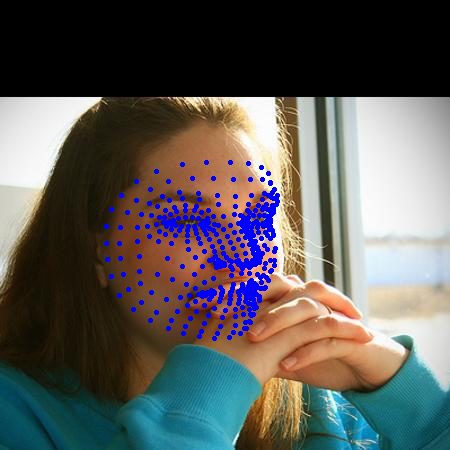

In [36]:
show_image_landmarks()

In [20]:
def show_image_axis(image_path=None):

  image_path = random.choice(res_imgs)
  faceModule = mediapipe.solutions.face_mesh

  with faceModule.FaceMesh(static_image_mode=True) as face:
    frame = cv2.imread(image_path + '.jpg')
    results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
      for face in results.multi_face_landmarks:
        for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              shape = frame.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])

        mat = sio.loadmat(image_path + '.mat')
        pitch_true = mat["Pose_Para"][0][0]
        yaw_true = mat["Pose_Para"][0][1]
        roll_true = mat["Pose_Para"][0][2]

        tdx= X[res_imgs.index(image_path)][1]
        tdy= Y[res_imgs.index(image_path)][1]

        draw_axis(frame,pitch_true,yaw_true,roll_true, tdx, tdy)


  return cv2_imshow(frame)

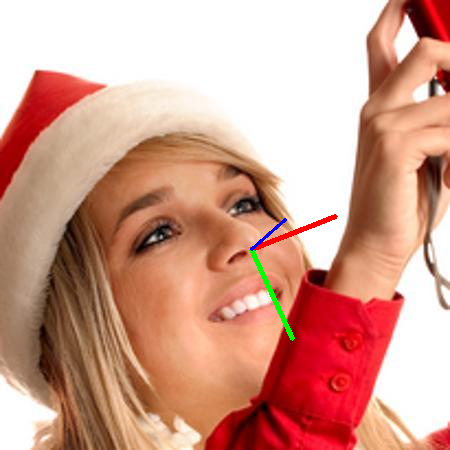

In [21]:
show_image_axis()

In [30]:
images=[]
output_name= '/content/tilted.avi'
vidcap = cv2.VideoCapture('/content/drive/MyDrive/IMG_9914.MOV')

success,image = vidcap.read()
count = 0

imageWidth = int(vidcap.get(3))
imageHeight = int(vidcap.get(4))
fps = vidcap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_name, fourcc, fps, (imageWidth, imageHeight))

while success:
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  if success:
  # images.append(image)

    faceModule = mediapipe.solutions.face_mesh
    Xx=[]
    Yy=[]

    with faceModule.FaceMesh(static_image_mode=True) as face:
        results = face.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
          for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  shape = image.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  Xx.append(relative_x)
                  Yy.append(relative_y)
          Xx=np.array(Xx).reshape(1,-1)        
          Yy=np.array(Yy).reshape(1,-1)        

          Mean_X = Xx - Xx[:,1].reshape(-1,1)
          Mean_Y = Yy - Yy[:,1].reshape(-1,1)

          X_171 = Xx[:,171]
          X_10 = Xx[:,10]
          Y_171 = Yy[:,171]
          Y_10 = Yy[:,10] 
          distance = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_171,Y_171)),axis = 0).reshape(-1,1)
          Norm_X = Mean_X / distance
          Norm_Y = Mean_Y / distance
          features = np.hstack([Norm_X,Norm_Y])

          pitch = pitch_model.predict(features)
          yaw = yaw_model.predict(features)
          roll = roll_model.predict(features)

          tdx= Xx[:,1]
          tdy= Yy[:,1]

          draw_axis(image,pitch,yaw,roll, tdx, tdy)
          images.append(image)
          
          # if cv2.waitKey(1) == ord('q'):
          #   break
    # cv2_imshow(image)
          count += 1

for i in images:
  out.write(i)          
   


In [32]:
from google.colab import files
files.download('/content/tilted.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
def test_image(path):
  image=cv2.imread(path)
  faceModule = mediapipe.solutions.face_mesh
  X=[]
  Y=[]
  with faceModule.FaceMesh(static_image_mode=True) as face:
    results = face.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
      for face in results.multi_face_landmarks:
        for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              X.append(relative_x)
              Y.append(relative_y)
      X=np.array(X).reshape(1,-1)        
      Y=np.array(Y).reshape(1,-1)        

      Mean_X = X - X[:,1].reshape(-1,1)
      Mean_Y = Y - Y[:,1].reshape(-1,1)

      X_171 = X[:,171]
      X_10 = X[:,10]
      Y_171 = Y[:,171]
      Y_10 = Y[:,10]

      distance = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_171,Y_171)),axis = 0).reshape(-1,1)
      Norm_X = Mean_X / distance
      Norm_Y = Mean_Y / distance

      features = np.hstack([Norm_X,Norm_Y])
        
      pitch = pitch_model.predict(features)
      yaw = yaw_model.predict(features)
      roll = roll_model.predict(features)

      tdx= X[:,1]
      tdy= Y[:,1]

      draw_axis(image,pitch,yaw,roll, tdx, tdy)
    return cv2_imshow(image)

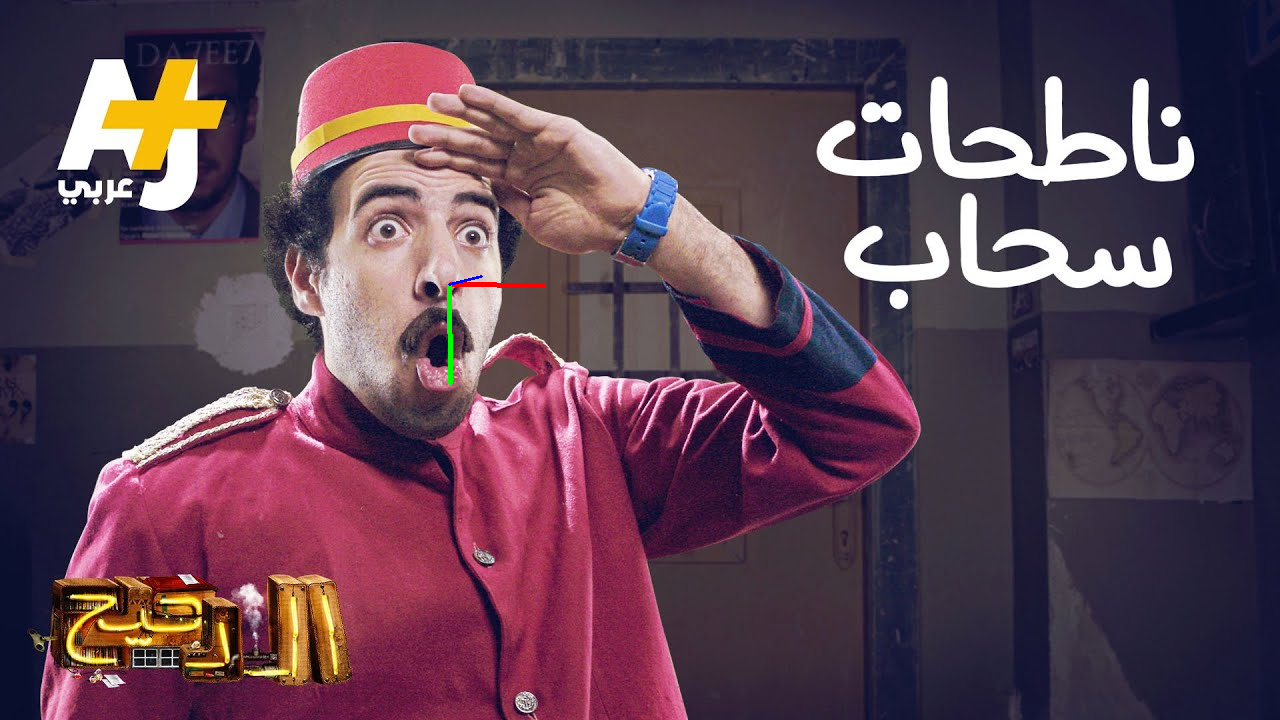

In [34]:
test_image('/content/1.jpg')